# <center>Spotify track popularity prediction
## Getting to know the data
Dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import optuna
import plotly.figure_factory as ff
import category_encoders as ce

from xgboost import XGBRegressor, XGBRFRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import pipeline
from sklearn import compose
from sklearn import metrics

In [2]:
# Imported modules parameters
sns.set_style('darkgrid')
plt.style.use('dark_background')
pio.templates.default = 'plotly_dark'
pio.renderers.default = 'png'

In [3]:
# Project constants
N_JOBS = -1
RANDOM_STATE = 42

In [4]:
data = pd.read_csv('data/SpotifyFeatures.csv.zip')
data.sample(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
22208,Electronic,Valentino Khan,Lick It,2AUHVjR5lhg6GcztbGvRkc,68,0.00596,0.800,216960,0.8430,0.119000,E,0.1080,-1.611,Major,0.0633,124.989,4/4,0.6440
31283,Anime,KANA-BOON,Penguin,4JpOrivE75wyNRnHD2IkVV,23,0.02840,0.508,322613,0.5460,0.000000,G,0.1430,-5.618,Major,0.0284,77.999,4/4,0.6690
176241,Jazz,Andy Montañez,Payaso,0EvqtUYBpFOtAGrfWI2DtL,40,0.22300,0.683,280333,0.4940,0.000000,D,0.0690,-10.265,Major,0.0402,108.105,4/4,0.8390
136706,Reggae,Los Cafres,Waiting en Vano,5sAK5JZrlRF0QMY6AL0Ygl,41,0.53000,0.524,298199,0.6470,0.000004,F,0.8900,-6.879,Major,0.0446,79.679,4/4,0.7860
143032,Indie,Ben Howard,Black Flies,3JhNsyNQSyrsHcnFRHZN1e,58,0.44000,0.581,381507,0.3600,0.005890,G#,0.0924,-13.174,Major,0.0289,132.469,4/4,0.1070
188134,Ska,The Specials,Maggie's Farm,6FWe7DCkGDmo5F1WIxkPkH,28,0.10000,0.579,212493,0.5800,0.000000,C,0.2040,-12.590,Major,0.1050,134.657,4/4,0.8070
54117,R&B,Brandy,The Boy Is Mine,6sHsXIJoEN5JpdkGMQDJxt,67,0.53900,0.704,294787,0.7070,0.001060,C#,0.3180,-6.537,Minor,0.0391,93.145,4/4,0.7610
39498,Electronic,Little Dragon,Only One,7AKonCuSi35fHQ313x11PN,28,0.43700,0.513,246947,0.4240,0.046800,G,0.3550,-10.771,Minor,0.0342,124.987,4/4,0.1460
198239,Soundtrack,Mark Mancina,"One Family - From ""Tarzan""/Score",6bEwXNsFspvKjmOjLiVbCQ,41,0.89700,0.124,228066,0.0461,0.911000,A#,0.1150,-24.065,Minor,0.0326,79.564,4/4,0.0375
183723,Movie,Pam Miller,Rock-A-Bye Piglet,1iXAgIYKN4VKtOBvhMxFV1,12,0.88300,0.629,233440,0.2310,0.000004,G#,0.0771,-10.568,Major,0.0302,111.809,3/4,0.1630


In [5]:
data.info()
display(
    data.describe(exclude=object).T,
    data.describe(include=object).T
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,count,mean,std,min,25%,50%,75%,max
popularity,232725.0,41.127502,18.189948,0.00000,29.0000,43.000000,55.0000,100.000
acousticness,232725.0,0.368560,0.354768,0.00000,0.0376,0.232000,0.7220,0.996
danceability,232725.0,0.554364,0.185608,0.05690,0.4350,0.571000,0.6920,0.989
duration_ms,232725.0,235122.339306,118935.909299,15387.00000,182857.0000,220427.000000,265768.0000,5552917.000
energy,232725.0,0.570958,0.263456,0.00002,0.3850,0.605000,0.7870,0.999
instrumentalness,232725.0,0.148301,0.302768,0.00000,0.0000,0.000044,0.0358,0.999
liveness,232725.0,0.215009,0.198273,0.00967,0.0974,0.128000,0.2640,1.000
loudness,232725.0,-9.569885,5.998204,-52.45700,-11.7710,-7.762000,-5.5010,3.744
speechiness,232725.0,0.120765,0.185518,0.02220,0.0367,0.050100,0.1050,0.967
tempo,232725.0,117.666585,30.898907,30.37900,92.9590,115.778000,139.0540,242.903


,count,unique,top,freq
genre,232725,27,Comedy,9681
artist_name,232725,14564,Giuseppe Verdi,1394
track_name,232725,148615,Home,100
track_id,232725,176774,3R73Y7X53MIQZWnKloWq5i,8
key,232725,12,C,27583
mode,232725,2,Major,151744
time_signature,232725,5,4/4,200760


### Duplicates

In [6]:
dupl = data.drop(columns=['track_id', 'track_name']).duplicated().sum()
print(f'Total duplicates(exclude track_id and track_name features): {dupl}')
# Delete duplicates
data.drop_duplicates(subset=data.drop(columns=['track_id', 'track_name']).columns, ignore_index=True, inplace=True)
print('Duplicates deleted.')

Total duplicates(exclude track_id and track_name features): 55
Duplicates deleted.


In [7]:
data['genre'] = data['genre'].apply(lambda x: "Children's music" if 'Children' in x else x)

### Gaps

In [8]:
pd.DataFrame(data.isna().sum(), columns=['NaN\'s']).T

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
NaN's,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visualisation

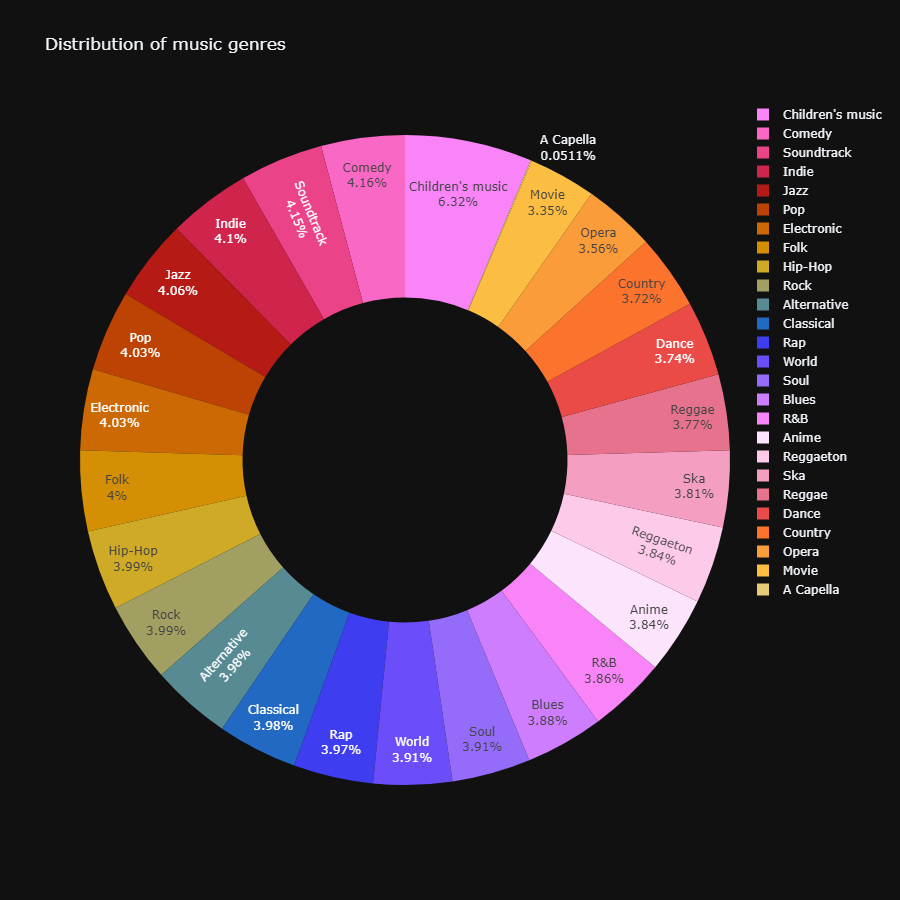

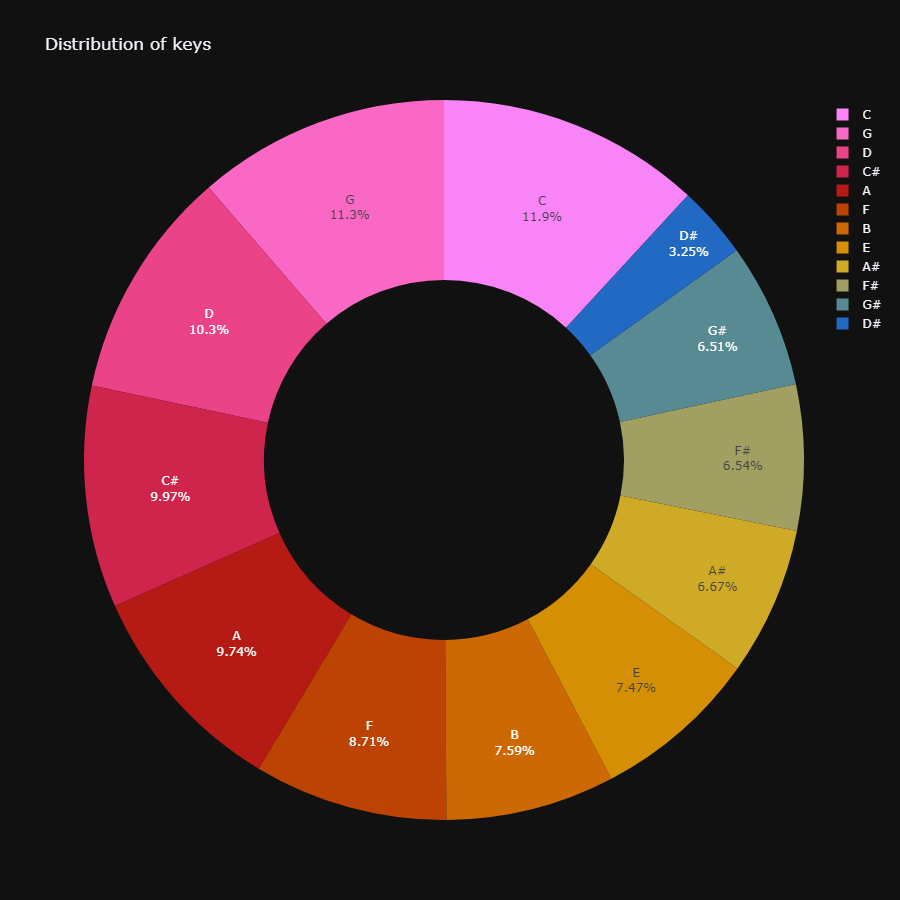

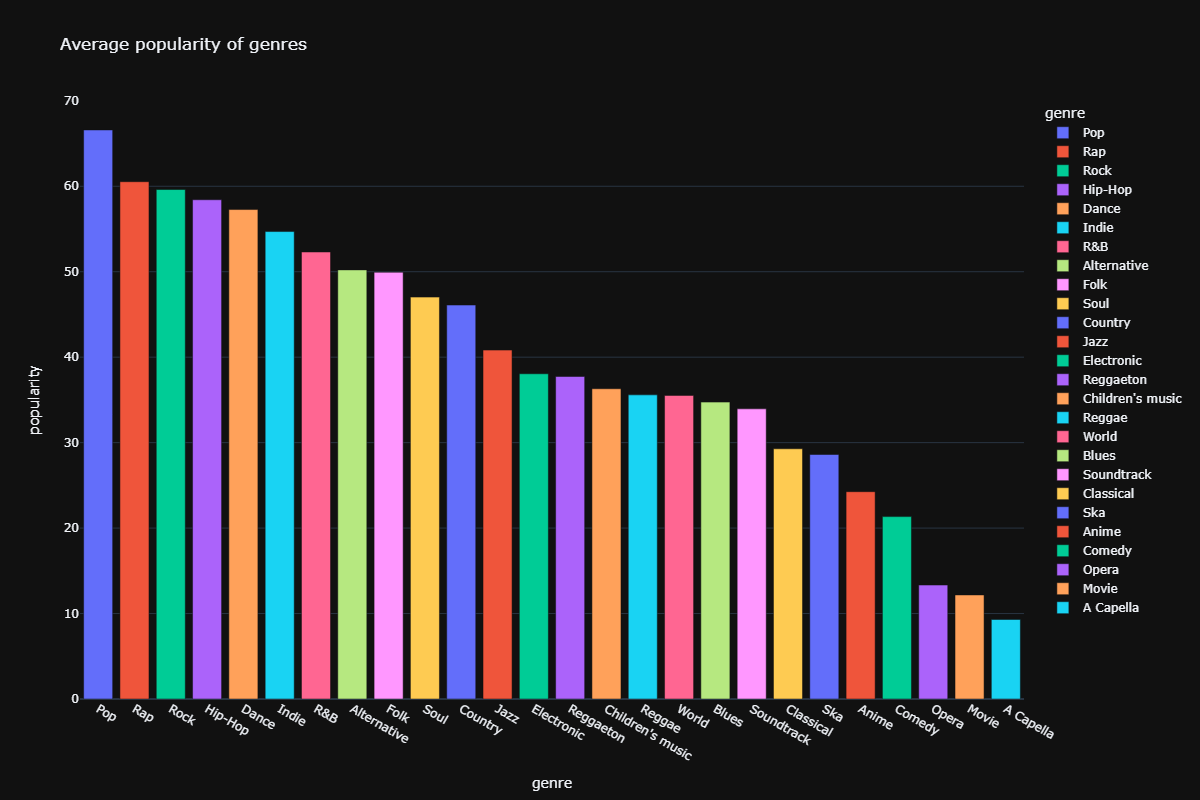

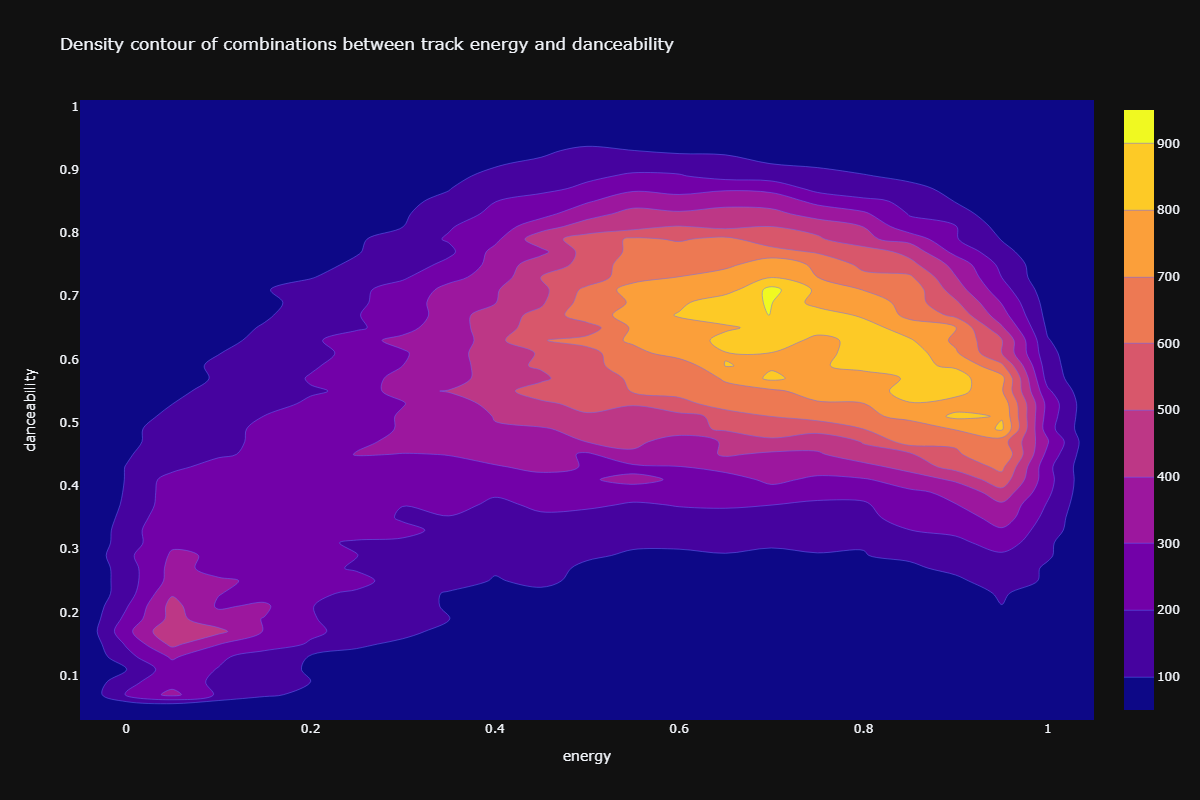

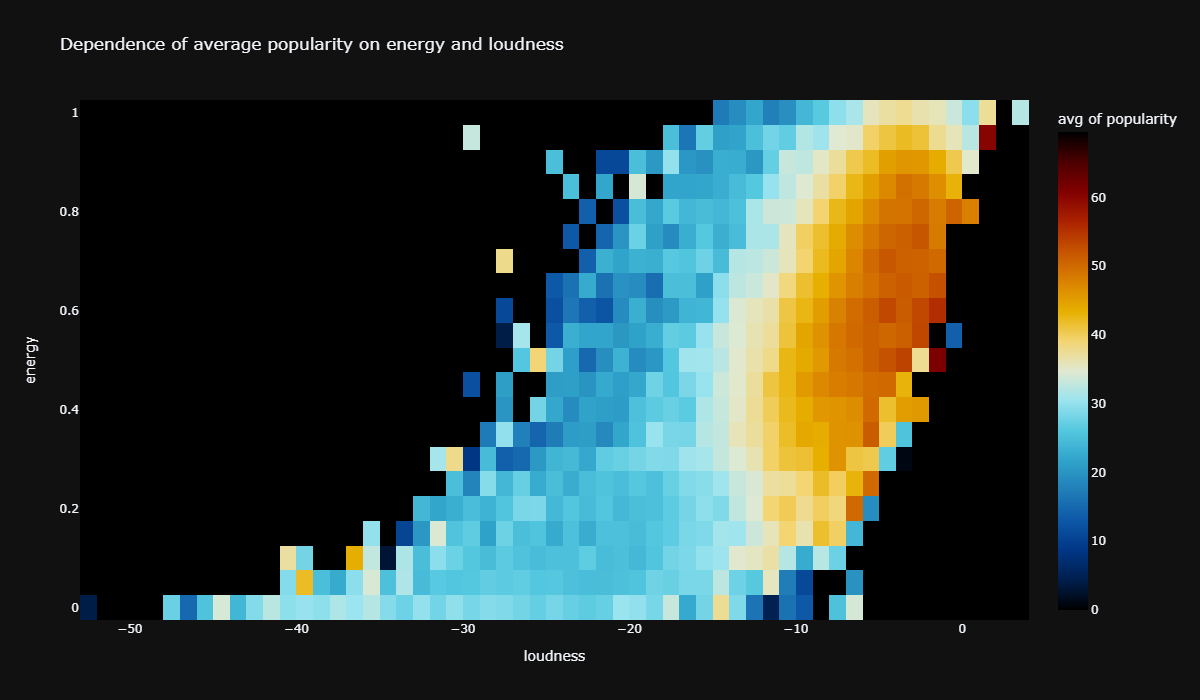

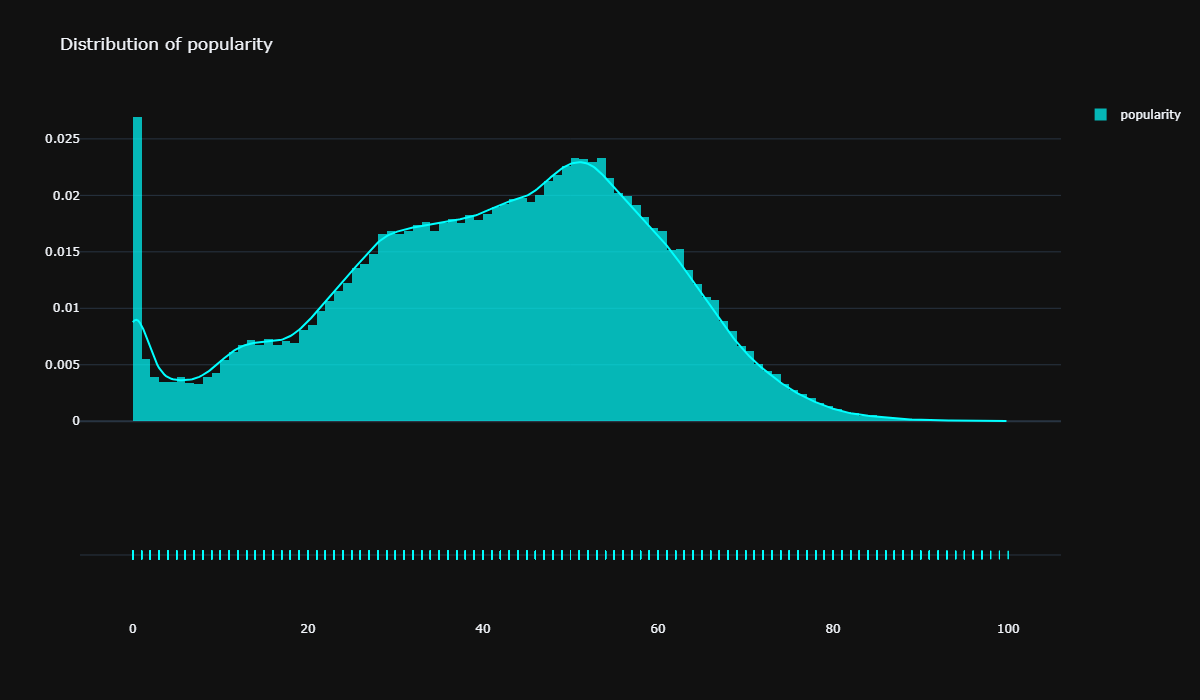

In [9]:
genre_pie = px.pie(
    data,
    names='genre',
    width=900,
    height=900,
    hole=0.5,
    title='Distribution of music genres',
    color_discrete_sequence=px.colors.cyclical.mrybm
)
genre_pie.update_traces(textinfo='percent+label')

keys_pie = px.pie(
    data,
    names='key',
    width=900,
    height=900,
    hole=0.5,
    title='Distribution of keys',
    color_discrete_sequence=px.colors.cyclical.mrybm
)
keys_pie.update_traces(textinfo='percent+label')

pop_grouped = data.groupby(by='genre', as_index=False)['popularity'].mean().sort_values(by='popularity', ascending=False)
popularity_by_genre = px.bar(
    pop_grouped,
    x='genre',
    y='popularity',
    color='genre',
    width=1200,
    height=800,
    title='Average popularity of genres'
)

danceability = px.density_contour(
    data,
    y='danceability',
    x='energy',
    width=1200,
    height=800,
    title='Density contour of combinations between track energy and danceability',
)
danceability.update_traces(contours_coloring='fill')

energy_loudness = px.density_heatmap(
    data,
    y='energy',
    x='loudness',
    z='popularity',
    height=700,
    width=1200,
    histfunc='avg',
    title='Dependence of average popularity on energy and loudness',
    color_continuous_scale=px.colors.cyclical.IceFire
)

popularity_dist = ff.create_distplot(
    hist_data=[data['popularity'].tolist()],
    group_labels=['popularity'],
    colors=['Cyan']
)
popularity_dist.update_layout(width=1200, height=700, title='Distribution of popularity')

genre_pie.show()
keys_pie.show()
popularity_by_genre.show()
danceability.show()
energy_loudness.show()
popularity_dist.show()

***
## EDA

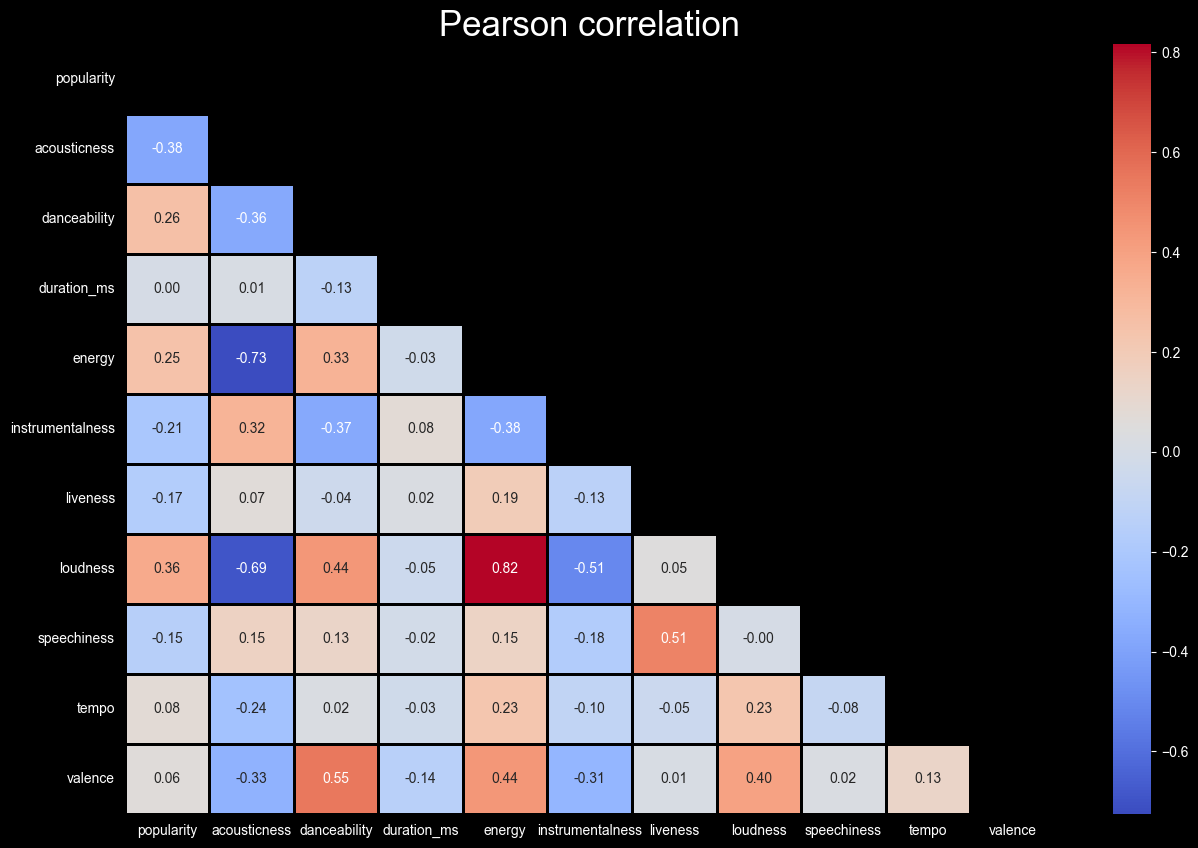

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(data.corr(numeric_only=True))
sns.heatmap(data.corr(numeric_only=True), ax=ax, annot=True, fmt='.2f', mask=mask, cmap='coolwarm', linewidths=1, linecolor='k')
ax.set_title('Pearson correlation', fontsize=25);

In [11]:
drop_cols = ['track_name', 'track_id', 'artist_name']
oh_cols = ['key', 'time_signature']
ord_cols = ['mode']
bin_cols = ['genre']
passthrough = data[[col for col in data.columns if data[col].dtype != object and col != 'popularity']].columns

oh_encoder = preprocessing.OneHotEncoder()
ord_encoder = preprocessing.OrdinalEncoder()
bin_encoder = ce.BinaryEncoder()

column_transformers = compose.make_column_transformer(
    (oh_encoder, oh_cols),
    (ord_encoder, ord_cols),
    (bin_encoder, bin_cols),
    ('drop', drop_cols),
    ('passthrough', passthrough)
)
column_transformers

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['key', 'time_signature']),
                                ('ordinalencoder', OrdinalEncoder(), ['mode']),
                                ('binaryencoder', BinaryEncoder(), ['genre']),
                                ('drop', 'drop',
                                 ['track_name', 'track_id', 'artist_name']),
                                ('passthrough', 'passthrough',
                                 Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object'))])

***
## Model building
### Data preprocessing

In [12]:
X, y = data.drop(columns='popularity'), data['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
kfold = KFold(n_splits=5)

def print_metrics(y_train_pred, y_test_pred):
    
    r2_train = round(metrics.r2_score(y_train, y_train_pred), 2)
    mae_train = round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
    
    r2_test = round(metrics.r2_score(y_test, y_test_pred), 2)
    mae_test = round(metrics.mean_absolute_error(y_test, y_test_pred), 2)
    
    metrics_df = pd.DataFrame({
        'Train': [r2_train, mae_train],
        'Test': [r2_test, mae_test]
    }, index=['R2', 'MAE']).style.background_gradient(axis=None)
    
    display(metrics_df)

(174502, 17) (58168, 17) (174502,) (58168,)


### LinearRegression

In [13]:
pipeline_lr = pipeline.make_pipeline(
    column_transformers,
    LinearRegression()
)
pipeline_lr.fit(X_train, y_train)

y_train_pred = pipeline_lr.predict(X_train)
y_test_pred = pipeline_lr.predict(X_test)
 
print_metrics(y_train_pred, y_test_pred)

,Train,Test
R2,0.320000,0.320000
MAE,11.740000,11.770000


### DecisionTreeRegressor

In [14]:
def optimize_pipeline(pipeline_, params, n_trials=20):
    study = optuna.create_study(study_name=pipeline_[-1].__class__.__name__, direction='maximize')
    optuna_cv = optuna.integration.OptunaSearchCV(
        estimator=pipeline_,
        param_distributions=params,
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        scoring='neg_mean_absolute_error',
        verbose=2,
        study=study
    )
    optuna_cv.fit(X_train, y_train)
    print('Best params:', optuna_cv.best_params_)
    print('Best cv score:', optuna_cv.best_score_)
    y_train_pred = optuna_cv.predict(X_train)
    y_test_pred = optuna_cv.predict(X_test)
    print_metrics(y_train_pred, y_test_pred)
    return optuna_cv

In [15]:
pipeline_dtr = pipeline.make_pipeline(column_transformers, DecisionTreeRegressor(random_state=RANDOM_STATE))
params_dtr=dict(
    decisiontreeregressor__max_depth=optuna.distributions.IntDistribution(10, 30),
    decisiontreeregressor__min_samples_split=optuna.distributions.IntDistribution(2, 30),
    decisiontreeregressor__min_samples_leaf=optuna.distributions.IntDistribution(1, 30)
)

best_dtr = optimize_pipeline(pipeline_dtr, params_dtr)

[I 2023-04-10 21:50:48,370] A new study created in memory with name: DecisionTreeRegressor
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_4208\49026187.py:3: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-04-10 21:50:48,398] Searching the best hyperparameters using 174502 samples...
[I 2023-04-10 21:51:05,472] Trial 5 finished with value: -7.651863231965729 and parameters: {'decisiontreeregressor__max_depth': 12, 'decisiontreeregressor__min_samples_split': 23, 'decisiontreeregressor__min_samples_leaf': 29}. Best is trial 5 with value: -7.651863231965729.
[I 2023-04-10 21:51:06,656] Trial 10 finished with value: -7.642547446242423 and parameters: {'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__min_samples_split': 12, 'decisiontreeregressor__min_samples_leaf': 17}. Best is trial 10 with value: -7.642547446242423.
[I 2023-04-10 21:51:07,594] Trial 9 finished with value: -7.6473611874228355 and

Best params: {'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__min_samples_split': 12, 'decisiontreeregressor__min_samples_leaf': 17}
Best cv score: -7.642547446242423


,Train,Test
R2,0.710000,0.690000
MAE,7.250000,7.540000


### RandomForestRegressor

In [16]:
pipeline_rf = pipeline.make_pipeline(column_transformers, RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS))
params_rf = dict(
    randomforestregressor__max_depth=optuna.distributions.IntDistribution(10, 30),
    randomforestregressor__min_samples_split=optuna.distributions.IntDistribution(2, 30),
    randomforestregressor__min_samples_leaf=optuna.distributions.IntDistribution(1, 30),
    randomforestregressor__n_estimators=optuna.distributions.IntDistribution(50, 200)
)

best_rf = optimize_pipeline(pipeline_rf, params_rf)

[I 2023-04-10 21:51:27,401] A new study created in memory with name: RandomForestRegressor
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_4208\49026187.py:3: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-04-10 21:51:27,419] Searching the best hyperparameters using 174502 samples...
[I 2023-04-10 22:02:30,100] Trial 0 finished with value: -7.445908795719885 and parameters: {'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 27, 'randomforestregressor__n_estimators': 50}. Best is trial 0 with value: -7.445908795719885.
[I 2023-04-10 22:02:38,118] Trial 11 finished with value: -7.383614655518746 and parameters: {'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__min_samples_leaf': 9, 'randomforestregressor__n_estimators': 65}. Best is trial 11 with value: -7.38361465551874

Best params: {'randomforestregressor__max_depth': 22, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 6, 'randomforestregressor__n_estimators': 169}
Best cv score: -7.3638143308101265


,Train,Test
R2,0.840000,0.710000
MAE,5.240000,7.320000


### GradientBoostingRegressor

In [17]:
pipeline_gbr = pipeline.make_pipeline(column_transformers, GradientBoostingRegressor(random_state=RANDOM_STATE))
params_gbr = dict(
    gradientboostingregressor__learning_rate=optuna.distributions.FloatDistribution(0.01, 1),
    gradientboostingregressor__n_estimators=optuna.distributions.IntDistribution(10, 150),
    gradientboostingregressor__min_samples_split=optuna.distributions.IntDistribution(2, 30),
    gradientboostingregressor__min_samples_leaf=optuna.distributions.IntDistribution(1, 30),
    gradientboostingregressor__max_depth=optuna.distributions.IntDistribution(2, 5)
)
best_gbr = optimize_pipeline(pipeline_gbr, params_gbr)

[I 2023-04-10 22:29:57,221] A new study created in memory with name: GradientBoostingRegressor
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_4208\49026187.py:3: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-04-10 22:29:57,246] Searching the best hyperparameters using 174502 samples...
[I 2023-04-10 22:30:58,248] Trial 0 finished with value: -9.083785215120788 and parameters: {'gradientboostingregressor__learning_rate': 0.5662484435737899, 'gradientboostingregressor__n_estimators': 10, 'gradientboostingregressor__min_samples_split': 19, 'gradientboostingregressor__min_samples_leaf': 17, 'gradientboostingregressor__max_depth': 4}. Best is trial 0 with value: -9.083785215120788.
[I 2023-04-10 22:33:21,693] Trial 9 finished with value: -9.534476386490928 and parameters: {'gradientboostingregressor__learning_rate': 0.9734583814398892, 'gradientboostingregressor__n_estimators': 74, 'gradientboostingregressor__m

Best params: {'gradientboostingregressor__learning_rate': 0.6652067779495543, 'gradientboostingregressor__n_estimators': 107, 'gradientboostingregressor__min_samples_split': 8, 'gradientboostingregressor__min_samples_leaf': 13, 'gradientboostingregressor__max_depth': 4}
Best cv score: -8.024623759836615


,Train,Test
R2,0.690000,0.670000
MAE,7.660000,7.930000


### XGBoostRegressor

In [18]:
pipeline_xgbr = pipeline.make_pipeline(column_transformers, XGBRegressor(verbosity=2, n_jobs=N_JOBS, tree_method='gpu_hist', random_state=RANDOM_STATE))
params_xgbr = dict(
    xgbregressor__n_estimators=optuna.distributions.IntDistribution(10, 100),
    xgbregressor__max_depth=optuna.distributions.IntDistribution(2, 15),
    xgbregressor__max_leaves=optuna.distributions.IntDistribution(0, 50),
    xgbregressor__learning_rate=optuna.distributions.FloatDistribution(0.01, 1),
    xgbregressor__booster=optuna.distributions.CategoricalDistribution(['dart', 'gbtree'])
)
best_xgbr = optimize_pipeline(pipeline_xgbr, params_xgbr)

[I 2023-04-10 22:43:21,799] A new study created in memory with name: XGBRegressor
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_4208\49026187.py:3: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-04-10 22:43:21,827] Searching the best hyperparameters using 174502 samples...
[I 2023-04-10 22:43:31,290] Trial 0 finished with value: -10.749799381571263 and parameters: {'xgbregressor__n_estimators': 12, 'xgbregressor__max_depth': 2, 'xgbregressor__max_leaves': 19, 'xgbregressor__learning_rate': 0.5382978466788373, 'xgbregressor__booster': 'gbtree'}. Best is trial 0 with value: -10.749799381571263.
[I 2023-04-10 22:43:33,894] Trial 8 finished with value: -12.799994261589049 and parameters: {'xgbregressor__n_estimators': 11, 'xgbregressor__max_depth': 2, 'xgbregressor__max_leaves': 13, 'xgbregressor__learning_rate': 0.1919624119182633, 'xgbregressor__booster': 'dart'}. Best is trial 0 with value: -10.749799381571

Best params: {'xgbregressor__n_estimators': 45, 'xgbregressor__max_depth': 9, 'xgbregressor__max_leaves': 29, 'xgbregressor__learning_rate': 0.5380525382648943, 'xgbregressor__booster': 'gbtree'}
Best cv score: -7.908934009266053


,Train,Test
R2,0.680000,0.670000
MAE,7.720000,7.870000


### XGBRFRegressor

In [19]:
pipeline_xgbrf = pipeline.make_pipeline(column_transformers, XGBRFRegressor(verbosity=2, n_jobs=N_JOBS, tree_method='gpu_hist', random_state=RANDOM_STATE))
params_xgbrf = dict(
    xgbrfregressor__n_estimators=optuna.distributions.IntDistribution(10, 100),
    xgbrfregressor__max_depth=optuna.distributions.IntDistribution(2, 30),
    xgbrfregressor__max_leaves=optuna.distributions.IntDistribution(0, 50),
    xgbrfregressor__learning_rate=optuna.distributions.FloatDistribution(0.01, 1),
    xgbrfregressor__booster=optuna.distributions.CategoricalDistribution(['dart', 'gbtree'])
)
best_xgbrf = optimize_pipeline(pipeline_xgbrf, params_xgbrf)

[I 2023-04-10 22:45:20,980] A new study created in memory with name: XGBRFRegressor
C:\Users\sadeyes\AppData\Local\Temp\ipykernel_4208\49026187.py:3: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-04-10 22:45:21,009] Searching the best hyperparameters using 174502 samples...
[I 2023-04-10 22:45:34,438] Trial 6 finished with value: -28.842519962744518 and parameters: {'xgbrfregressor__n_estimators': 63, 'xgbrfregressor__max_depth': 12, 'xgbrfregressor__max_leaves': 1, 'xgbrfregressor__learning_rate': 0.32771781051467314, 'xgbrfregressor__booster': 'gbtree'}. Best is trial 6 with value: -28.842519962744518.
[I 2023-04-10 22:45:35,106] Trial 7 finished with value: -22.507433268304883 and parameters: {'xgbrfregressor__n_estimators': 20, 'xgbrfregressor__max_depth': 3, 'xgbrfregressor__max_leaves': 25, 'xgbrfregressor__learning_rate': 0.4973511251198744, 'xgbrfregressor__booster': 'dart'}. Best is trial 7 with 

Best params: {'xgbrfregressor__n_estimators': 29, 'xgbrfregressor__max_depth': 16, 'xgbrfregressor__max_leaves': 36, 'xgbrfregressor__learning_rate': 0.8957926568663989, 'xgbrfregressor__booster': 'gbtree'}
Best cv score: -10.694205684244192


,Train,Test
R2,0.470000,0.480000
MAE,10.400000,10.390000


***
## Conclusion
|Model|$MAE$|$R^2$|
|-----|-----|-----------|
|LinearRegression|11.77|0.32|
|DecisionTreeClassifier|7.54|0.69|
|***RandomForestRegressor***|***7.32***|***0.71***|
|GradientBoostingRegressor|7.93|0.67|
|XGBoostRegressor|7.87|0.67|
|XGBRFRegressor|10.39|0.48|

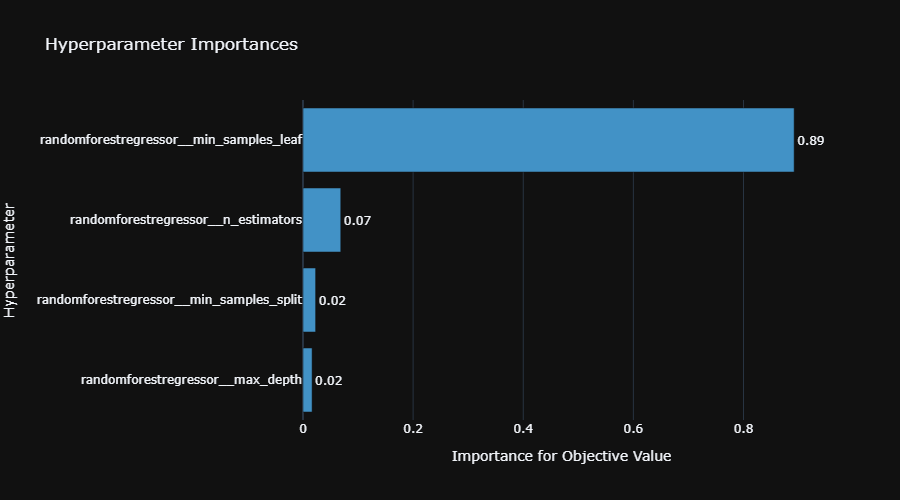

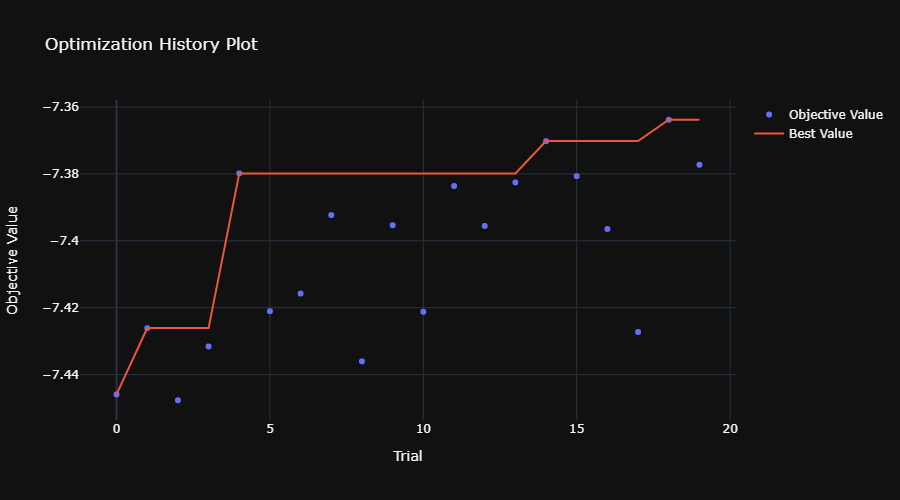

In [40]:
optuna.visualization.plot_param_importances(best_rf.study).update_layout(dict(width=900, height=500)).show()
optuna.visualization.plot_optimization_history(best_rf.study).update_layout(dict(width=900, height=500)).show()